Load all the required libraries

In [ ]:
!pip install statsmodels
!pip install pmdarima

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from math import sqrt
from pylab import rcParams

In [ ]:
#IMPORT DATA
btc_data = pd.read_csv('/content/BTC2019-2024.csv',index_col='Date')
bnb_data = pd.read_csv('/content/BNB2019-2024.csv',index_col='Date')
eth_data = pd.read_csv('/content/ETH2019-2024.csv',index_col='Date')

btc_data = btc_data.dropna()
bnb_data = bnb_data.dropna()
eth_data = eth_data.dropna()

print('Shape of bitcoin data', btc_data.shape)
print('Shape of binance data', bnb_data.shape)
print('Shape of ethereum data', eth_data.shape)


Shape of bitcoin data (1815, 7)
Shape of binance data (1815, 7)
Shape of ethereum data (1815, 7)


In [ ]:
btc_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415


In [ ]:
bnb_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


In [ ]:
eth_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2019-03-01,136.836243,138.995270,136.434784,136.443619,136.443619,3756124824
1,1,2019-03-02,136.350082,137.184799,132.436386,134.206955,134.206955,3747176425
2,2,2019-03-03,134.786118,135.849289,131.328857,132.249420,132.249420,3454374053
3,3,2019-03-04,132.157883,132.729141,125.402702,127.774124,127.774124,4008171341
4,4,2019-03-05,127.792953,138.229980,126.735298,137.822388,137.822388,4764849990


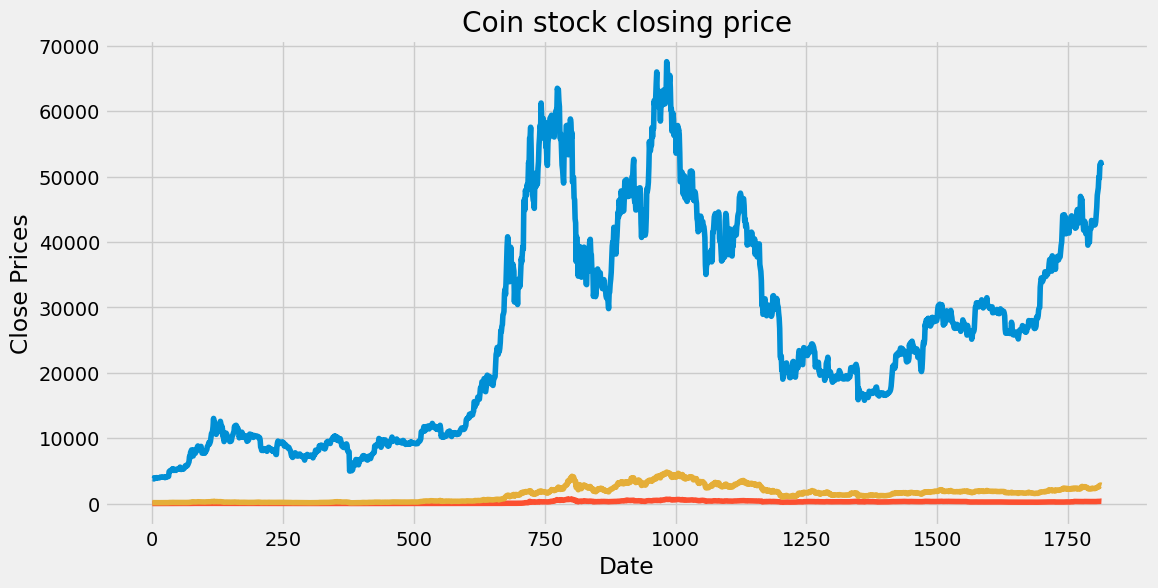

In [ ]:
#Plot "Close" price of btc, bnb, and eth.
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(btc_data['Close'])
plt.plot(bnb_data['Close'])
plt.plot(eth_data['Close'])
plt.title('Coin stock closing price')
plt.show()

Only using 'Close' for predicting

In [ ]:
df_btc = btc_data['Close']
df_bnb = bnb_data['Close']
df_eth = eth_data['Close']

Test for staionarity

In [ ]:
def test_stationarity(timeseries):
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
#Test bitcoin dataset
test_stationarity(btc_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.383119
p-value                           0.590342
#Lags Used                        9.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [ ]:
#Test Binance Dataset
test_stationarity(bnb_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.777350
p-value                           0.391763
#Lags Used                       25.000000
Number of Observations Used    1789.000000
Critical Value (1%)              -3.434011
Critical Value (5%)              -2.863157
Critical Value (10%)             -2.567631
dtype: float64


In [ ]:
#Test Ethereum Dataset
test_stationarity(eth_data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.416200
p-value                           0.574486
#Lags Used                       17.000000
Number of Observations Used    1797.000000
Critical Value (1%)              -3.433994
Critical Value (5%)              -2.863150
Critical Value (10%)             -2.567627
dtype: float64


Eliminate trend

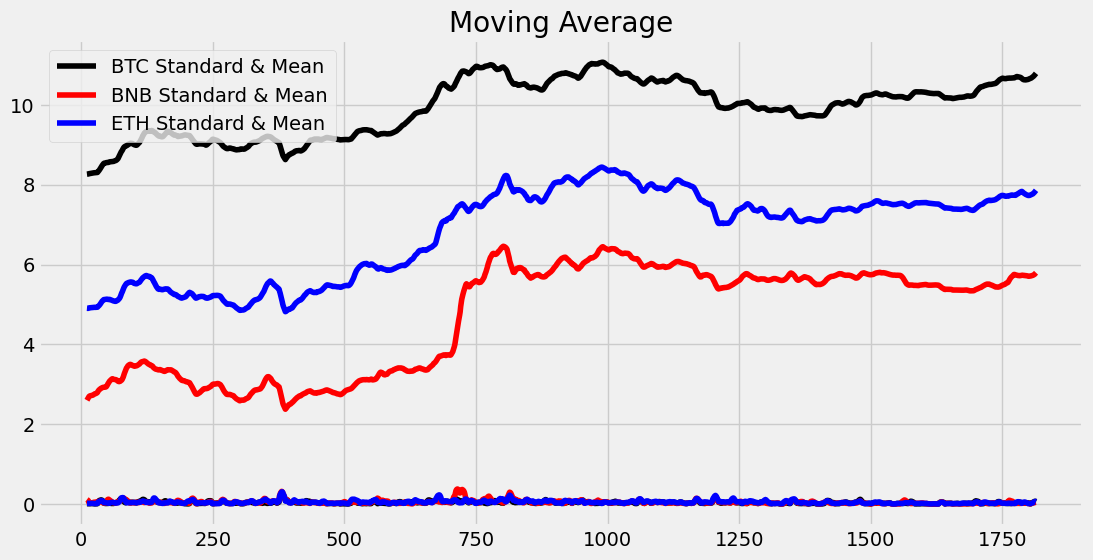

In [ ]:
rcParams['figure.figsize'] = 12, 6

df_log_btc = np.log(df_btc)
df_log_btc = np.log(df_btc)
df_log_btc = np.log(df_btc)

moving_avg_btc = df_log_btc.rolling(12).mean()
moving_avg_bnb = df_log_bnb.rolling(12).mean()
moving_avg_eth = df_log_eth.rolling(12).mean()

std_dev_btc = df_log_btc.rolling(12).std()
std_dev_bnb = df_log_bnb.rolling(12).std()
std_dev_eth = df_log_eth.rolling(12).std()

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev_btc, color ="black", label = "BTC Standard & Mean")
plt.plot(std_dev_bnb, color ="red", label = "BNB Standard & Mean")
plt.plot(std_dev_eth, color ="blue", label = "ETH Standard & Mean")
plt.plot(moving_avg_btc, color="black")
plt.plot(moving_avg_bnb, color="red")
plt.plot(moving_avg_eth, color="blue")
plt.legend()
plt.show()

Get the p,d,q by using Auto Arima

In [ ]:
#BITCOIN
stepwise_fit = auto_arima(df_log_btc, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6963.600, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6962.753, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6965.128, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6964.809, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6961.803, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6965.640, Time=0.76 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6963.641, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6963.643, Time=1.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6966.847, Time=3.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6963.381, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6965.369, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6965.709, Time=0.88 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 10.188 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3487.423
Date:                Mon, 06 May 2024   AIC                          -6966.847
Time:                        15:24:24   BIC                          -6944.834
Sample:                             0   HQIC                         -6958.724
                               - 1815                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      1.684      0.092      -0.000       0.005
ar.L1         -0.6990      0.147     -4.767      0.000      -0.986      -0.412
ma.L1          0.6512      0.155      4.196      0.000       0.347       0.955
sigma2         0.0013   1.36e-05     92.166      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             27936.43
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for bitcoin dataset as 1, 1 and 1 respectively.

In [ ]:
#BINANCE
stepwise_fit = auto_arima(df_log_bnb, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5878.213, Time=3.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5854.318, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5861.921, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5860.394, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5853.499, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5874.286, Time=4.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5873.468, Time=0.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5874.655, Time=1.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5875.421, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5875.342, Time=1.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5874.224, Time=3.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5871.465, Time=0.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5873.486, Time=6.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-5876.833, Time=0.54 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(2, 1, 2)   Log Likelihood                2945.106
Date:                Mon, 06 May 2024   AIC                          -5878.213
Time:                        15:24:51   BIC                          -5845.193
Sample:                             0   HQIC                         -5866.029
                               - 1815                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      1.004      0.315      -0.000       0.002
ar.L1          0.0612      0.086      0.713      0.476      -0.107       0.229
ar.L2          0.6649      0.088      7.598      0.000       0.493       0.836
ma.L1         -0.1135      0.093     -1.226      0.220      -0.295       0.068
ma.L2         -0.5722      0.093     -6.158      0.000      -0.754      -0.390
sigma2         0.0023   2.47e-05     92.237      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             38070.91
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for binance dataset as 2, 1 and 2 respectively.

In [ ]:
#ETHEREUM
stepwise_fit = auto_arima(df_log_eth, trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6113.984, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6106.230, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6111.993, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6111.315, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6105.748, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6115.700, Time=1.79 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6113.185, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6117.658, Time=1.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6111.592, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6113.586, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6116.987, Time=1.56 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 9.398 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1815
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3062.829
Date:                Mon, 06 May 2024   AIC                          -6117.658
Time:                        15:25:01   BIC                          -6095.645
Sample:                             0   HQIC                         -6109.535
                               - 1815                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.002      1.543      0.123      -0.001       0.007
ar.L1         -0.7946      0.080     -9.979      0.000      -0.951      -0.639
ma.L1          0.7385      0.089      8.303      0.000       0.564       0.913
sigma2         0.0020   2.37e-05     84.469      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             20080.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA model provided the best value of p,d, and q for ethereum dataset as 1, 1 and 1 respectively.

Split data into train and test set

In [ ]:
#BITCOIN
train_btc = df_log_btc.iloc[:-350]
test_btc = df_log_btc.iloc[-350:]
print(train_btc.shape,test_btc.shape)

(1465,) (350,)


In [ ]:
#BINANCE
train_bnb = df_log_bnb.iloc[:-350]
test_bnb = df_log_bnb.iloc[-350:]
print(train_bnb.shape,test_bnb.shape)

(1465,) (350,)


In [ ]:
#ETHEREUM
train_eth = df_log_eth.iloc[:-350]
test_eth = df_log_eth.iloc[-350:]
print(train_eth.shape,test_eth.shape)

(1465,) (350,)


Modeling

In [ ]:
#BITCOIN
model = ARIMA(train_btc, order=(1,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1465
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2716.624
Date:                Mon, 06 May 2024   AIC                          -5427.249
Time:                        15:27:20   BIC                          -5411.382
Sample:                             0   HQIC                         -5421.331
                               - 1465                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5379      0.253     -2.126      0.033      -1.034      -0.042
ma.L1          0.4830      0.262      1.845      0.065      -0.030       0.996
sigma2         0.0014   1.72e-05     83.322      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             19761.83
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Predict Results
start = len(train_btc)
end = len(train_btc) + len(test_btc) -1
pred = model.predict(start=start, end=end, typ='levels')
print(pred)

1465    10.013730
1466    10.014269
1467    10.013979
1468    10.014135
1469    10.014051
          ...    
1810    10.014080
1811    10.014080
1812    10.014080
1813    10.014080
1814    10.014080
Name: predicted_mean, Length: 350, dtype: float64


In [ ]:
#Report Performance

rmse_btc = sqrt(mean_squared_error(test_btc,pred))
print('RMSE: '+str(rmse_btc))

mse_btc = mean_squared_error(test_btc, pred)
print('MSE: '+str(mse_btc))

mae_btc = mean_absolute_error(test_btc, pred)
print('MAE: '+str(mse_btc))



RMSE: 0.4013171977081249
MSE: 0.16105549317630222
MAE: 0.16105549317630222


In [ ]:
model2 = ARIMA(df_log_btc, order=(1,1,5))
model2 = model2.fit()
btc_data.tail()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2024-02-13,1810,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
2024-02-14,1811,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
2024-02-15,1812,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533
2024-02-16,1813,51937.726563,52537.968750,51641.367188,52160.203125,52160.203125,28180567298
2024-02-17,1814,52161.675781,52180.582031,51558.039063,51724.253906,51724.253906,22865082368


In [ ]:
index_future_dates = pd.date_range(start='2024-02-18', end='2024-05-18')
pred_btc = model2.predict(start=len(btc_data), end=len(btc_data)+90, typ = 'levels').rename('ARIMA prediction')
pred_btc.index = index_future_dates

In [ ]:
#BINANCE
model = ARIMA(train_bnb, order=(2,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1465
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2253.556
Date:                Mon, 06 May 2024   AIC                          -4497.111
Time:                        15:30:23   BIC                          -4470.667
Sample:                             0   HQIC                         -4487.248
                               - 1465                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1976      0.068      2.887      0.004       0.063       0.332
ar.L2          0.7152      0.062     11.444      0.000       0.593       0.838
ma.L1         -0.2618      0.076     -3.442      0.001      -0.411      -0.113
ma.L2         -0.6148      0.071     -8.674      0.000      -0.754      -0.476
sigma2         0.0027   3.42e-05     78.743      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             22344.36
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Predict Results
start = len(train_btc)
end = len(train_btc) + len(test_btc) -1
pred = model.predict(start=start, end=end, typ='levels')
print(pred)

1465    5.665463
1466    5.665205
1467    5.663219
1468    5.662642
1469    5.661108
          ...   
1810    5.640310
1811    5.640310
1812    5.640310
1813    5.640310
1814    5.640310
Name: predicted_mean, Length: 350, dtype: float64


In [ ]:
#Report Performance

rmse_bnb = sqrt(mean_squared_error(test_bnb,pred))
print('RMSE: '+str(rmse_bnb))

mse_bnb = mean_squared_error(test_bnb, pred)
print('MSE: '+str(mse_bnb))

mae_bnb = mean_absolute_error(test_bnb, pred)
print('MAE: '+str(mse_bnb))

RMSE: 1.7899612625015433
MSE: 3.2039613212561187
MAE: 3.2039613212561187


In [ ]:
model2 = ARIMA(df_log_bnb, order=(2,1,2))
model2 = model2.fit()
btc_data.tail()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2024-02-13,1810,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
2024-02-14,1811,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
2024-02-15,1812,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533
2024-02-16,1813,51937.726563,52537.968750,51641.367188,52160.203125,52160.203125,28180567298
2024-02-17,1814,52161.675781,52180.582031,51558.039063,51724.253906,51724.253906,22865082368


In [ ]:
index_future_dates = pd.date_range(start='2024-02-18', end='2024-05-18')
pred_bnb = model2.predict(start=len(bnb_data), end=len(bnb_data)+90, typ = 'levels').rename('ARIMA prediction')
pred_bnb.index = index_future_dates
print(pred_bnb)

2024-02-18    5.879803
2024-02-19    5.880450
2024-02-20    5.882111
2024-02-21    5.882551
2024-02-22    5.883410
                ...   
2024-05-14    5.885052
2024-05-15    5.885052
2024-05-16    5.885052
2024-05-17    5.885052
2024-05-18    5.885052
Freq: D, Name: ARIMA prediction, Length: 91, dtype: float64


In [ ]:
#ETHEREUM
model = ARIMA(train_eth, order=(1,1,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1465
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2356.685
Date:                Mon, 06 May 2024   AIC                          -4707.371
Time:                        15:46:38   BIC                          -4691.504
Sample:                             0   HQIC                         -4701.453
                               - 1465                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8105      0.088     -9.190      0.000      -0.983      -0.638
ma.L1          0.7561      0.099      7.641      0.000       0.562       0.950
sigma2         0.0023    3.1e-05     75.551      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             12740.15
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -1.31
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Predict Results
start = len(train_eth)
end = len(train_eth) + len(test_eth) -1
pred = model.predict(start=start, end=end, typ='levels')
print(pred)

1465    7.356156
1466    7.356734
1467    7.356265
1468    7.356646
1469    7.356337
          ...   
1810    7.356475
1811    7.356475
1812    7.356475
1813    7.356475
1814    7.356475
Name: predicted_mean, Length: 350, dtype: float64


In [ ]:
rmse_eth = sqrt(mean_squared_error(test_eth, pred))
print('RMSE: '+str(rmse_eth))

mse_eth = mean_squared_error(test_eth, pred)
print('MSE: '+str(mse_eth))

mae_eth = mean_absolute_error(test_eth, pred)
print('MAE: '+str(mse_eth))

RMSE: 0.24013351851094195
MSE: 0.0576641067124449
MAE: 0.0576641067124449


In [ ]:
model2 = ARIMA(df_log_eth, order=(2,1,2))
model2 = model2.fit()
btc_data.tail()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2024-02-13,1810,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
2024-02-14,1811,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
2024-02-15,1812,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533
2024-02-16,1813,51937.726563,52537.968750,51641.367188,52160.203125,52160.203125,28180567298
2024-02-17,1814,52161.675781,52180.582031,51558.039063,51724.253906,51724.253906,22865082368


In [ ]:
index_future_dates = pd.date_range(start='2024-02-18', end='2024-05-18')
pred_eth = model2.predict(start=len(eth_data), end=len(eth_data)+90, typ = 'levels').rename('ARIMA prediction')
pred_eth.index = index_future_dates
print(pred_eth)

2024-02-18    7.933064
2024-02-19    7.932909
2024-02-20    7.934775
2024-02-21    7.934929
2024-02-22    7.936308
                ...   
2024-05-14    7.946413
2024-05-15    7.946415
2024-05-16    7.946416
2024-05-17    7.946417
2024-05-18    7.946419
Freq: D, Name: ARIMA prediction, Length: 91, dtype: float64
